In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ========================================================
# = Parameters for plotting
# ========================================================
FONT_SIZE = 14
rc={'font.size': FONT_SIZE, 'axes.labelsize': FONT_SIZE, 'legend.fontsize': FONT_SIZE,
    'axes.titlesize': FONT_SIZE, 'xtick.labelsize': FONT_SIZE, 'ytick.labelsize': FONT_SIZE}
plt.rcParams.update(**rc)
plt.rc('font', weight='bold')

# 1 Functions

## 1.1 Functions for data preprocessing

In [3]:
##==============================================================================
## cleaning data: outlier, missing data at midnight, and consective missing data
##==============================================================================
def preprocess_missingdata(df, MIDP, pvsize):
    # Step 1. replace the negative values with zero
    df.loc[df[MIDP]<0, MIDP] = 0
    # Step 2. replace outlier (larger than pvsize) with nan
    df_outlier_idx = df[df[MIDP].astype(float) > 1.2*pvsize]
    df.iloc[df_outlier_idx.index.to_list(), 1] = np.nan
    
    # Step 3. fill the nan
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

In [4]:
##==============================================================================
## calculate mean and variance by excluding zero values
##==============================================================================
def calculate_mean_variance(time_series):
    # Step 4. calculate mean and variance
    filtered_values = np.array(time_series)[np.array(time_series) != 0]

    mean = np.mean(filtered_values)
    std_deviation = np.std(filtered_values)
    return mean, std_deviation

## 1.2 Functions for Clear-Sky Days

In [5]:
# Create a function to apply to each element in the DataFrame
def set_to_true_or_nan(x):
    if pd.isna(x):
        return x
    return x > 0.8

In [6]:
##========================================================================
## clear-sky days
##========================================================================
def clearsky_cal(date_start, date_end):
    # read the clear-sky model generation for different PV sites
    df_site = pd.read_csv('../../preprocessed_data/PVsite_daily_20231016.csv')

    df_site_clearsky = df_site.filter(like='EnergyYield.kWh.Daily')
    split_columns = df_site_clearsky.columns.str.split(':').str[1]
    df_site_clearsky.columns = split_columns
    df_site_clearsky.insert(0, 'date', df_site['date'].values)
    df_site_clearsky = df_site_clearsky[(df_site_clearsky['date'] >= date_start) & (df_site_clearsky['date'] <= date_end)]

    # read the expected generation of different PV sites
    df_site_expected = df_site.filter(like='Irrad.kWh.m2.Daily')
    split_columns = df_site_expected.columns.str.split(':').str[1]
    df_site_expected.columns = split_columns
    df_site_expected.insert(0, 'date', df_site['date'].values)
    df_site_expected = df_site_expected[(df_site_expected['date'] >= date_start) & (df_site_expected['date'] <= date_end)]

    # Calculate the cloudiness
    df_cloudiness = df_site_clearsky.copy()
    df_cloudiness.iloc[:, 1:] = df_site_expected.iloc[:, 1:]/df_site_clearsky.iloc[:, 1:]
    df_cloudiness.iloc[:, 1:] = df_cloudiness.iloc[:, 1:].astype(float)
    df_cloudiness.dropna(how='all', axis=1, inplace=True)
    df_cloudiness.iloc[:, 1:].fillna(axis=1, method='ffill', inplace=True)

    df_clearday_sites = df_cloudiness.copy()

    # Apply the function to the entire DataFrame
    df_clearday_sites.iloc[:, 1:] = df_clearday_sites.iloc[:, 1:].applymap(set_to_true_or_nan)
    return df_clearday_sites


In [7]:
# ========================================================
# = Read clear-sky days results
# ========================================================
def select_clearsky_days(date_list, df_clearday_sites, site_id):
    clearsky_dict = {}
    if 'SITE|'+site_id in df_clearday_sites.columns.to_list():
        df_clearsky = df_clearday_sites[['date', 'SITE|'+site_id]]
        # print(df_clearsky)
        for date_id in date_list:
            clearsky_col = df_clearsky.loc[df_clearsky['date']==date_id, 'SITE|'+site_id].values
            if len(clearsky_col) == 0:
                clearsky_or_not = 'None'
            else:
                clearsky_or_not = clearsky_col[0]
            clearsky_dict[date_id] = clearsky_or_not
        return clearsky_dict
    else:
        print('There is no data in the downloaded file for clear-sky days')
        return None

## 1.3 STL Function

In [8]:
from statsmodels.tsa.seasonal import STL

In [9]:
def STL_trend(time_series):
    stl = STL(time_series, period=10)
    result = stl.fit()
    trend = result.trend
    return trend

# 2 Parameter Settings

In [26]:

timeslots_daily = 12*24 # 15-min time resolution
start_date = '2022-01-01'
end_date = '2023-08-30'
threshold_low_cloudiness = 0.8
measure_name_expect = 'Irrad.kWh.m2.Daily' # expected generation
measure_name_clearsky = 'EnergyYield.kWh.Daily' # theoretical generation

effective_start_time = 5
effective_end_time = 20
effective_timeslots_daily = (effective_end_time-effective_start_time + 1)*4

short_term_easy_fault_list = ['Zero Generation', 'No Data', 'Non-Zero Tripping', 'Night-Time Generation', 'Exemplar Data AC', 'Generation Tripping']
short_term_concern_fault_list = ['Recurring Underperformance', 'Generation Clipping']

if_clearsky = True

# 3 Read Data

## 3.1. Raw Data

In [ ]:
# read meta table
df_monitors = pd.read_csv('../../input_data/MNTR_ddb_20230630.csv', header=0)
att_list = ['latitude', 'longitude', 'tilt', 'azimuth', 'loss', 'pvSizeWatt']
df_monitors['latitude'] = [x[1:] for x in df_monitors['latitude']]
# df_monitors

In [ ]:
# read labelled table
df_label = pd.read_csv('dataset/Diagno Labelling - FaultLabelsFinal.csv')
# df_label

In [ ]:
df_label_raw = df_label[df_label['faultName'].isin(short_term_concern_fault_list+short_term_easy_fault_list)]
# df_label_raw[df_label_raw['diagnoId']=='6923648e-16e0-43a6-b630-31138292836b']
# df_label_raw

## 3.2. Data preprocessing 

In [22]:
# read raw data with 5-min time resolution
file_path = '../../preprocessed_data/5min_rawdata_20230630.csv'
df_raw = pd.read_csv(file_path, header=0, index_col=0)
df_raw = df_raw[(df_raw['time'] >= start_date) & (df_raw['time'] < end_date)]
df_raw

,time,MNTR|6758049,MNTR|3516434,MNTR|2392161,MNTR|1098974_1_8_19,MNTR|1205793_1_3_1,MNTR|1112363_1_2_1,MNTR|a6e623b2-105d-47c5-a0e9-aa5e006a9faf,MNTR|7053139,MNTR|918954,...,MNTR|3172589,MNTR|7721843,MNTR|1162569_1_1_1,MNTR|1206026_1_2_1,MNTR|0001c02a2a1b,MNTR|918952,MNTR|1148485_1_1_1,MNTR|5556047,MNTR|6039646,MNTR|1189660_1_2_1
105120,2022-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105121,2022-01-01 00:05:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105122,2022-01-01 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105123,2022-01-01 00:15:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105124,2022-01-01 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262364,2023-06-30 23:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262365,2023-06-30 23:45:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262366,2023-06-30 23:50:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262367,2023-06-30 23:55:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# find monitors with raw data & labels
raw_monitor_list = df_raw.columns.str.split('|').str[-1].values[1:]
label_monitor_list = df_label_raw['diagnoId'].values
monitors_list = [value for value in raw_monitor_list if value in label_monitor_list]
monitors_list

['a6e623b2-105d-47c5-a0e9-aa5e006a9faf',
 'BOPQ-75B2-AIOH-HTPZ',
 '3430d8e7-22c4-4e3e-90e7-ceaf6164b517',
 'EY23-83LN-QK8Y-G8AE',
 '1046505_1_1_1',
 '22179934',
 '8937329',
 '1215481_1_1_1',
 '295222',
 '7193486a-bebd-4ff8-8c60-ae7000197adf',
 '304153',
 'X3AO-6QT3-6L55-AWKT',
 '7291508',
 'T6OM-8T9V-DW94-DCOY',
 '22181898',
 'b827eb7dd983',
 '2ZVN-HJT3-R0U9-ZAG8',
 '1149044_1_1_1',
 '4209851',
 '5973565',
 '1344416',
 '300720',
 '3ccd83a9-eaaa-4878-8bed-ad440053abe5',
 '1122995_1_2_1',
 '22228666',
 '1139335_1_2_1',
 '1176504_1_1_1',
 '2CQC-3H2V-Y6QJ-X041',
 '0001c0277af4',
 '7469530',
 'QCE4-RI42-LLQJ-A5YH',
 '1177474_1_1_1',
 'cfaf0a55-3253-481e-af81-7fb57fac7325',
 '5541097',
 '7382707',
 'b827ebc36dbf',
 '20463573',
 '987654358',
 'D6AD-U80D-JFCQ-GCVE',
 '4000767',
 '25554765',
 '25554675',
 '895042',
 '5380167',
 '6039648',
 '2bcc24d1-70be-4acd-af25-a2b8faa0220e',
 'f30df05b-254b-44bb-ba47-3b16ecae8ae9',
 'DD34108928763',
 '100001001',
 'D36U-90M0-XIHL-0QFU',
 '7807074',
 'Z7LN-O

# 4 Selection Clear-Sky Days

In [24]:
df_clearsky_sites = clearsky_cal(date_start=start_date, date_end=end_date)
df_clearsky_sites

,date,SITE|65e61db2-2bb3-4480-b495-96064d5ed331,SITE|4dddc226-3464-4c95-aded-875e490a2f02,SITE|d830cf82-d943-404a-8396-9b22141538a8,SITE|c9fcf61f-c1a9-48d8-b2bb-c843dbd69119,SITE|09640f46-ed55-45be-b243-dbbe126fc994,SITE|166b83a9-ad51-4ad2-b853-fdb1aa936f6d,SITE|d317a168-4257-4187-9603-3d4834532bbb,SITE|11fde49c-5cd0-429c-8013-97c9a1c1462d,SITE|d159d534-3a20-4bce-9df0-5772d555d4c8,...,SITE|75493355-27b1-4676-91b8-dc598d46813b,SITE|bca93ed0-dcc7-4262-9bb0-320f25b0d93e,SITE|1b3255ea-c7ee-41c3-bfa1-b8748787de0c,SITE|14708719-4bec-45c7-8364-e3b765109de2,SITE|8ee3f4c9-483b-426a-bd77-2a7121b9bbcf,SITE|93dcd16f-e2e9-422c-9099-fa50c46998a5,SITE|ef7f758c-4612-4025-acc4-47cfec16891f,SITE|6577b77e-93fe-486b-bc95-b77c5ce6a18e,SITE|4229b257-cc70-4d03-8c0a-1f0d930d792e,SITE|49965a47-7a49-4866-a11f-06cb600ac967
1096,2022-01-01,NaN,True,NaN,True,NaN,NaN,True,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,True
1097,2022-01-02,NaN,True,NaN,True,NaN,NaN,True,NaN,NaN,...,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,False
1098,2022-01-03,NaN,True,NaN,True,NaN,NaN,True,NaN,NaN,...,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,True
1099,2022-01-04,NaN,True,NaN,True,NaN,NaN,False,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,True
1100,2022-01-05,NaN,False,NaN,False,NaN,NaN,False,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1698,2023-08-26,True,True,False,True,NaN,NaN,NaN,True,False,...,True,True,True,True,True,True,NaN,NaN,NaN,True
1699,2023-08-27,True,True,True,True,NaN,NaN,NaN,True,True,...,False,True,True,True,False,False,NaN,NaN,NaN,True
1700,2023-08-28,True,True,False,True,NaN,NaN,NaN,True,True,...,True,True,True,True,True,True,NaN,NaN,NaN,True
1701,2023-08-29,True,True,False,True,NaN,NaN,NaN,True,True,...,True,True,True,True,True,True,NaN,NaN,NaN,True


# 5 Check the raw data is correct

# 6 Preprocess and Prepare the Samples

In [27]:
concern_fault_name = ''
df_timeslots = pd.DataFrame(index=range(timeslots_daily), columns=['time'])
df_timeslots['time'] = pd.date_range(start='2023-06-21 00:00:00', end='2023-06-21 23:59:59', freq='5min')
df_timeslots['time_str'] = df_timeslots['time'].dt.strftime('%Y-%m-%d %H:%M:%S')
df_timeslots['hour_min'] = df_timeslots['time_str'].str.split(' ').str[-1]
df_timeslots['hour'] = df_timeslots['time'].dt.hour
df_effective_timeslots = df_timeslots[(df_timeslots['hour']>=effective_start_time)&(df_timeslots['hour']<=effective_end_time)]
df_effective_timeslots.index=range(len(df_effective_timeslots))
df_effective_timeslots
# df_timeslots

,time,time_str,hour_min,hour
0,2023-06-21 05:00:00,2023-06-21 05:00:00,05:00:00,5
1,2023-06-21 05:05:00,2023-06-21 05:05:00,05:05:00,5
2,2023-06-21 05:10:00,2023-06-21 05:10:00,05:10:00,5
3,2023-06-21 05:15:00,2023-06-21 05:15:00,05:15:00,5
4,2023-06-21 05:20:00,2023-06-21 05:20:00,05:20:00,5
...,...,...,...,...
187,2023-06-21 20:35:00,2023-06-21 20:35:00,20:35:00,20
188,2023-06-21 20:40:00,2023-06-21 20:40:00,20:40:00,20
189,2023-06-21 20:45:00,2023-06-21 20:45:00,20:45:00,20
190,2023-06-21 20:50:00,2023-06-21 20:50:00,20:50:00,20


In [29]:

df_ml_raw = pd.DataFrame(columns=['date'] + df_effective_timeslots['hour_min'].values.tolist() + ['dcPvsize', 'faultID', 'faultname', 'MID', 'ClearSky'])
df_ml_normalized = pd.DataFrame(columns=['date'] + df_effective_timeslots['hour_min'].values.tolist() + ['dcPvsize', 'faultID', 'faultname', 'MID', 'ClearSky'])
df_ml_stl_norm = pd.DataFrame(columns=['date'] + df_effective_timeslots['hour_min'].values.tolist() + ['dcPvsize', 'faultID', 'faultname', 'MID', 'ClearSky'])
for mid in monitors_list:
    # name and parameters
    midname = 'MNTR|' + mid
    site_id = str(df_label_raw.loc[df_label_raw['diagnoId']==mid, ['siteId']].values[0][0])
    print('='*20)
    print(site_id)
    df_label_mid = df_label_raw[df_label_raw['diagnoId']==mid]
    df_label_mid.index = np.arange(len(df_label_mid))
    dcPvsize = df_label_raw.loc[df_label_raw['diagnoId']==mid, ['dcSize']].values[0][0]
    dcPvsize = dcPvsize*1000
    # raw data of the monitor
    df_mid = df_raw[['time', midname]]
    df_mid['time_datelike'] = pd.to_datetime(df_mid['time'])
    df_mid['date'] = df_mid['time_datelike'].dt.date
    df_mid['hour'] = df_mid['time_datelike'].dt.hour
    df_mid['date'] = pd.to_datetime(df_mid['date']).dt.strftime('%Y-%m-%d')
    df_mid = df_mid[(df_mid['hour']>=effective_start_time) & (df_mid['hour']<=effective_end_time)]
    df_mid.index = np.arange(len(df_mid))
    # processing the data
    df_mid = preprocess_missingdata(df=df_mid, MIDP=midname, pvsize=dcPvsize)

    # calculate mean and variance
    mean_value, dev_value = calculate_mean_variance(df_mid[midname].values)
    print('mean:{}, std_deviation: {}'.format(mean_value, dev_value))
    # calculate maxmum value
    maxvalue = df_mid[midname].max()
    print('maximum value: {}, dc_PVsize:{}'.format(maxvalue, dcPvsize))

    # find the date list with faults
    for i in range(len(df_label_mid)):
        faultid, faultname = df_label_mid.iloc[i][['faultCode', 'faultName']].values
        # print(faultid, faultname)
        mid_date_start, mid_date_end = df_label_mid.iloc[i, :][['faultStartdate', 'faultEnddate']].values
        date_list = pd.date_range(start=mid_date_start, end=mid_date_end).strftime('%Y-%m-%d').values.tolist()

        # mark clear-sky days
        clearsky_dict = select_clearsky_days(date_list=date_list, df_clearday_sites=df_clearsky_sites, site_id=site_id)
        # print(clearsky_dict)
        if clearsky_dict is not None:
            for dateid in date_list:
                power_value = df_mid.loc[df_mid['date']==dateid, midname].values
                if len(power_value)!=0:
                    ## === use maximum and minimum values for normalization
                    # power_norm = power_value/maxvalue
                    
                    ## === use mean and variance values for normalization
                    power_norm = (power_value - mean_value) / dev_value
                    clearsky_or_not = clearsky_dict[dateid]
                    value_list = [dateid] + power_value.tolist() + [dcPvsize, faultid, faultname, midname, clearsky_or_not]
                    value_norm_list = [dateid] + power_norm.tolist() + [dcPvsize, faultid, faultname, midname, clearsky_or_not]
                    # print(value_norm_list)

                    # calculate the STL trend
                    trend = STL_trend(time_series=power_norm)
                    value_stl_list = [dateid] + trend.tolist() + [dcPvsize, faultid, faultname, midname, clearsky_or_not]
                    # print(value_stl_list)
                    # print(value_list)
                    new_row_raw = {}
                    new_row_norm = {}
                    new_row_stl = {}
                    for j, col in enumerate(df_ml_raw.columns.to_list()):
                        new_row_raw[col] = value_list[j]
                        new_row_norm[col] = value_norm_list[j]
                        new_row_stl[col] = value_stl_list[j]
                    df_ml_raw = df_ml_raw.append(new_row_raw, ignore_index=True)
                    df_ml_normalized = df_ml_normalized.append(new_row_norm, ignore_index=True)
                    df_ml_stl_norm = df_ml_stl_norm.append(new_row_stl, ignore_index=True)

c2b6be72-3b29-4a75-a833-dd9a13cc165e
mean:14934.53290044056, std_deviation: 7840.723561616239
maximum value: 27440.0, dc_PVsize:33250.0
f17b5190-5afe-45d5-9360-d4aa5b688a51
mean:4415.087099238801, std_deviation: 3759.313381343902
maximum value: 16089.0, dc_PVsize:20090.0
7198f1b7-b861-4088-a8de-6be5f5803b8b
mean:1563.1658763686526, std_deviation: 1299.3949394835267
maximum value: 4835.0, dc_PVsize:5000.0
There is no data in the downloaded file for clear-sky days
5125d005-e4bd-4a69-9e20-558bd67ade6a
mean:1904.9734653183307, std_deviation: 1566.443022653961
maximum value: 4971.0, dc_PVsize:6000.0
8aa37e23-8df6-480a-8e14-1bde779f201b
mean:7884.345408153763, std_deviation: 7670.541122336594
maximum value: 29485.0, dc_PVsize:30000.0
22121018
mean:9189.526713709678, std_deviation: 7677.893213288063
maximum value: 30031.0, dc_PVsize:34200.0
There is no data in the downloaded file for clear-sky days
8660450
mean:17128.9011320033, std_deviation: 11484.890307261221
maximum value: 30027.0, dc_PVs

In [30]:
df_ml_normalized.head()

,date,05:00:00,05:05:00,05:10:00,05:15:00,05:20:00,05:25:00,05:30:00,05:35:00,05:40:00,...,20:35:00,20:40:00,20:45:00,20:50:00,20:55:00,dcPvsize,faultID,faultname,MID,ClearSky
0,2022-12-22,-1.903974,-1.893771,-1.885863,-1.875405,-1.863416,-1.851428,-1.839567,-1.825282,-1.811380,...,-1.904739,-1.904739,-1.904739,-1.904739,-1.904739,33250.0,L1F002,Generation Clipping,MNTR|a6e623b2-105d-47c5-a0e9-aa5e006a9faf,True
1,2022-12-23,-1.904739,-1.898235,-1.887266,-1.876043,-1.864564,-1.852703,-1.841480,-1.829619,-1.814696,...,-1.904739,-1.904739,-1.904739,-1.904739,-1.904739,33250.0,L1F002,Generation Clipping,MNTR|a6e623b2-105d-47c5-a0e9-aa5e006a9faf,True
2,2022-12-24,-1.902443,-1.894153,-1.887011,-1.876936,-1.866477,-1.855509,-1.843775,-1.831659,-1.819033,...,-1.904739,-1.904739,-1.904739,-1.904739,-1.904739,33250.0,L1F002,Generation Clipping,MNTR|a6e623b2-105d-47c5-a0e9-aa5e006a9faf,True
3,2022-12-25,-1.904739,-1.904739,-1.901168,-1.893261,-1.884971,-1.874257,-1.862013,-1.847346,-1.829236,...,-1.904739,-1.904739,-1.904739,-1.904739,-1.904739,33250.0,L1F002,Generation Clipping,MNTR|a6e623b2-105d-47c5-a0e9-aa5e006a9faf,True
4,2022-12-26,-1.904739,-1.900785,-1.893771,-1.887266,-1.876298,-1.864819,-1.854616,-1.848367,-1.844541,...,-1.904739,-1.904739,-1.904739,-1.904739,-1.904739,33250.0,L1F002,Generation Clipping,MNTR|a6e623b2-105d-47c5-a0e9-aa5e006a9faf,True


In [27]:
# df_clipping = df_ml_raw[df_ml_raw['faultname']=='Generation Clipping'].copy()
# df_clipping.index = range(len(df_clipping))
# df_clipping_norm = df_ml_normalized[df_ml_normalized['faultname']=='Generation Clipping'].copy()
# df_clipping_norm.index = range(len(df_clipping_norm))
# df_clipping_norm

In [31]:
df_recurring = df_ml_raw[df_ml_raw['faultname']=='Recurring Underperformance'].copy()
df_recurring.index = range(len(df_recurring))
df_recurring_norm = df_ml_normalized[df_ml_normalized['faultname']=='Recurring Underperformance'].copy()
df_recurring_norm.index = range(len(df_recurring_norm))
df_recurring_stl = df_ml_stl_norm[df_ml_stl_norm['faultname']=='Recurring Underperformance'].copy()
df_recurring_stl.index = range(len(df_recurring_stl))
df_recurring_norm

,date,05:00:00,05:05:00,05:10:00,05:15:00,05:20:00,05:25:00,05:30:00,05:35:00,05:40:00,...,20:35:00,20:40:00,20:45:00,20:50:00,20:55:00,dcPvsize,faultID,faultname,MID,ClearSky
0,2022-06-06,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,...,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,20090.0,L1F004,Recurring Underperformance,MNTR|BOPQ-75B2-AIOH-HTPZ,True
1,2022-06-07,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,...,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,20090.0,L1F004,Recurring Underperformance,MNTR|BOPQ-75B2-AIOH-HTPZ,True
2,2022-06-08,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,...,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,20090.0,L1F004,Recurring Underperformance,MNTR|BOPQ-75B2-AIOH-HTPZ,True
3,2022-06-09,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,...,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,20090.0,L1F004,Recurring Underperformance,MNTR|BOPQ-75B2-AIOH-HTPZ,True
4,2022-06-10,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,...,-1.174440,-1.174440,-1.174440,-1.174440,-1.174440,20090.0,L1F004,Recurring Underperformance,MNTR|BOPQ-75B2-AIOH-HTPZ,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,2023-05-20,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,...,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,36000.0,L1F004,Recurring Underperformance,MNTR|330135,True
406,2023-05-21,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,...,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,36000.0,L1F004,Recurring Underperformance,MNTR|330135,True
407,2023-05-22,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,...,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,36000.0,L1F004,Recurring Underperformance,MNTR|330135,True
408,2023-05-23,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,...,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,36000.0,L1F004,Recurring Underperformance,MNTR|330135,True


In [33]:
def plot_check(start_index, end_index, df_raw, df_norm, df_stl, df_effective_timeslots):
    for i in range(start_index, end_index):
        normvalues_plot = df_norm.iloc[i, :].loc[df_effective_timeslots['hour_min'].values.tolist()].values
        values_plot = df_raw.iloc[i, :].loc[df_effective_timeslots['hour_min'].values.tolist()].values
        stl_value = df_stl.iloc[i, :].loc[df_effective_timeslots['hour_min'].values.tolist()].values
        mid = df_norm.iloc[i,:]['MID']
        date = df_norm.iloc[i,:]['date']
        clearsky = df_norm.iloc[i, :]['ClearSky']
        plt.figure(figsize=(12, 6))
        plt.subplot(311)
        plt.plot(np.arange(len(values_plot)), values_plot, label='Original_{}_{}_{}'.format(date, mid, clearsky))
        plt.legend()
        plt.title('Original Time Series')
        plt.subplot(312)
        plt.plot(np.arange(len(values_plot)), normvalues_plot, label='Normalized')
        plt.title('Normalized Time Series')
        plt.subplot(313)
        plt.plot(np.arange(len(values_plot)), stl_value, label='STL')
        plt.title('STL Trend')


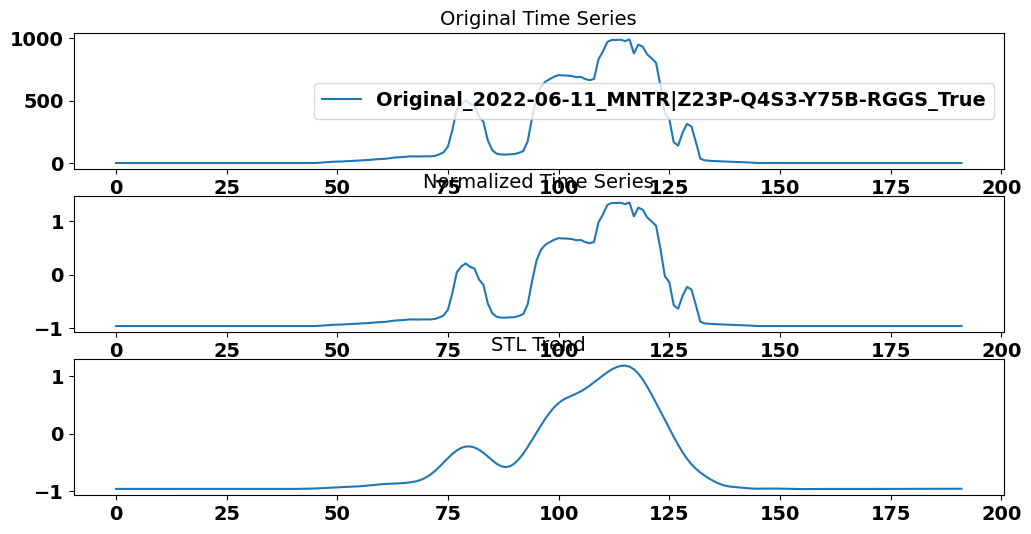

In [35]:
plot_check(start_index=305, end_index=306, df_raw=df_recurring, df_norm=df_recurring_norm, df_stl=df_recurring_stl, df_effective_timeslots=df_effective_timeslots)

Text(0.5, 1.0, 'Normalized Time Series')

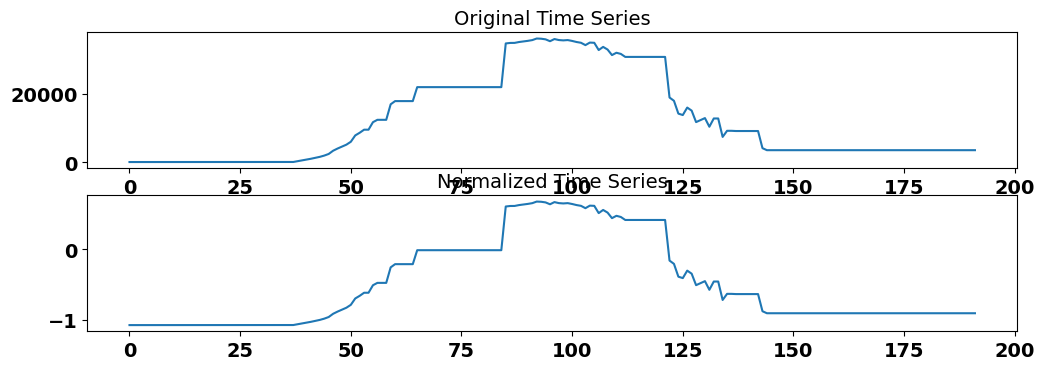

In [36]:
normvalues_plot = df_ml_normalized.iloc[1726, :].loc[df_effective_timeslots['hour_min'].values.tolist()].values
values_plot = df_ml_raw.iloc[1726, :].loc[df_effective_timeslots['hour_min'].values.tolist()].values
plt.figure(figsize=(12, 6))

plt.subplot(311)
plt.plot(np.arange(len(values_plot)), values_plot, label='Original')
plt.title('Original Time Series')
plt.subplot(312)
plt.plot(np.arange(len(values_plot)), normvalues_plot, label='Normalized')
plt.title('Normalized Time Series')

In [37]:
row_nan = df_ml_normalized.isna().any(axis=1)
row_nan[row_nan==True]

173     True
174     True
206     True
207     True
208     True
        ... 
2101    True
2102    True
2103    True
2104    True
2105    True
Length: 796, dtype: bool

In [38]:
nan_in_columns = df_ml_normalized.isna().any()
nan_in_columns[nan_in_columns==True]

ClearSky    True
dtype: bool

In [39]:

# faultname_list = df_ml_normalized['faultname'].unique()
faultname_list = ['Recurring Underperformance', 'Generation Clipping', 'Zero Generation', 'No Data', 'Non-Zero Tripping', 'Night-Time Generation', 'Exemplar Data AC', 'Generation Tripping']
label_mapping = {key: value for key, value in zip(faultname_list, range(len(faultname_list)))}
print(label_mapping)
labelnum_mapping = {value: key for key, value in zip(faultname_list, range(len(faultname_list)))}
print(labelnum_mapping)

{'Recurring Underperformance': 0, 'Generation Clipping': 1, 'Zero Generation': 2, 'No Data': 3, 'Non-Zero Tripping': 4, 'Night-Time Generation': 5, 'Exemplar Data AC': 6, 'Generation Tripping': 7}
{0: 'Recurring Underperformance', 1: 'Generation Clipping', 2: 'Zero Generation', 3: 'No Data', 4: 'Non-Zero Tripping', 5: 'Night-Time Generation', 6: 'Exemplar Data AC', 7: 'Generation Tripping'}


In [40]:
df_ml_normalized['Label'] = df_ml_normalized['faultname'].replace(label_mapping)
df_ml_normalized.iloc[153:, 100:]

,13:15:00,13:20:00,13:25:00,13:30:00,13:35:00,13:40:00,13:45:00,13:50:00,13:55:00,14:00:00,...,20:40:00,20:45:00,20:50:00,20:55:00,dcPvsize,faultID,faultname,MID,ClearSky,Label
153,0.527200,1.685711,1.466614,-0.256146,-0.790381,0.983401,0.533202,-0.424220,0.143030,0.755300,...,-1.927883,-1.927883,-1.927883,-1.927883,20000.0,L1F002,Generation Clipping,MNTR|300720,True,1
154,0.440161,0.278090,0.197054,-0.694339,-0.511258,0.545208,1.514635,0.908368,1.013414,1.742736,...,-1.927883,-1.927883,-1.927883,-1.927883,20000.0,L1F002,Generation Clipping,MNTR|300720,True,1
155,1.772749,1.772749,1.769748,1.766746,1.772749,1.772749,1.487623,1.592670,1.748738,1.691713,...,-1.927883,-1.927883,-1.927883,-1.927883,20000.0,L1F002,Generation Clipping,MNTR|300720,True,1
156,1.772749,1.772749,1.772749,1.772749,1.772749,1.772749,1.772749,1.772749,1.772749,1.772749,...,-1.927883,-1.927883,-1.927883,-1.927883,20000.0,L1F002,Generation Clipping,MNTR|300720,True,1
157,1.691713,1.748738,1.769748,1.700717,1.559655,1.766746,1.754741,1.766746,1.766746,1.766746,...,-1.927883,-1.927883,-1.927883,-1.927883,20000.0,L1F002,Generation Clipping,MNTR|300720,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,1.898387,1.896872,1.882678,1.882678,1.882678,1.882678,1.833432,1.833432,1.833432,1.793576,...,-1.133556,-1.133556,-1.133556,-1.133556,78120.0,L1F002,Generation Clipping,MNTR|0001c02a2a1b,True,1
2324,1.850265,1.859267,1.859267,1.859267,1.859267,1.859267,1.806039,1.792407,1.780810,1.773843,...,-1.150001,-1.150001,-1.150001,-1.150001,78120.0,L1F002,Generation Clipping,MNTR|0001c02a2a1b,True,1
2325,1.002301,1.056784,1.187516,1.448072,1.448072,1.448072,1.360874,0.056926,1.637874,1.637874,...,-1.150001,-1.150001,-1.150001,-1.150001,78120.0,L1F002,Generation Clipping,MNTR|0001c02a2a1b,True,1
2326,2.022619,2.022307,2.021682,2.016525,2.016994,2.019650,2.021057,2.021369,2.002617,1.999648,...,-1.102601,-1.102601,-1.102601,-1.102601,21250.0,L1F002,Generation Clipping,MNTR|5556047,True,1


In [41]:
value_counts = df_ml_raw['faultname'].value_counts()
value_counts

No Data                       1310
Recurring Underperformance     410
Non-Zero Tripping              249
Generation Clipping            210
Zero Generation                 84
Exemplar Data AC                30
Night-Time Generation           28
Generation Tripping              7
Name: faultname, dtype: int64

## 4.1 Process the imbalance problem

In [42]:
df_rawrepeat_zero = df_ml_raw.loc[df_ml_raw[df_ml_raw['faultname']=='Zero Generation'].index.repeat(2)]
df_normrepeat_zero = df_ml_normalized.loc[df_ml_normalized[df_ml_normalized['faultname']=='Zero Generation'].index.repeat(2)]
df_rawrepeat_zero

,date,05:00:00,05:05:00,05:10:00,05:15:00,05:20:00,05:25:00,05:30:00,05:35:00,05:40:00,...,20:35:00,20:40:00,20:45:00,20:50:00,20:55:00,dcPvsize,faultID,faultname,MID,ClearSky
51,2022-09-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,46800.0,L1F003,Zero Generation,MNTR|304153,False
51,2022-09-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,46800.0,L1F003,Zero Generation,MNTR|304153,False
52,2022-09-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,46800.0,L1F003,Zero Generation,MNTR|304153,False
52,2022-09-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,46800.0,L1F003,Zero Generation,MNTR|304153,False
53,2022-09-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,46800.0,L1F003,Zero Generation,MNTR|304153,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,2022-12-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13000.0,L1F003,Zero Generation,MNTR|WHX2-R9OL-9NA5-DMC8,NaN
2066,2022-12-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13000.0,L1F003,Zero Generation,MNTR|WHX2-R9OL-9NA5-DMC8,NaN
2066,2022-12-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13000.0,L1F003,Zero Generation,MNTR|WHX2-R9OL-9NA5-DMC8,NaN
2067,2022-12-15,0.0,0.0,0.0,0.0,0.0,0.0,10.0,43.0,71.0,...,0.0,0.0,0.0,0.0,0.0,13000.0,L1F003,Zero Generation,MNTR|WHX2-R9OL-9NA5-DMC8,True


In [43]:
df_ml_raw = pd.concat([df_ml_raw, df_rawrepeat_zero], ignore_index=True)
df_ml_raw.index = np.arange(len(df_ml_raw))

df_ml_normalized = pd.concat([df_ml_normalized, df_normrepeat_zero], ignore_index=True)
df_ml_normalized.index = np.arange(len(df_ml_normalized))
df_ml_raw

,date,05:00:00,05:05:00,05:10:00,05:15:00,05:20:00,05:25:00,05:30:00,05:35:00,05:40:00,...,20:35:00,20:40:00,20:45:00,20:50:00,20:55:00,dcPvsize,faultID,faultname,MID,ClearSky
0,2022-12-22,6.0,86.0,148.0,230.0,324.0,418.0,511.0,623.0,732.0,...,0.0,0.0,0.0,0.0,0.0,33250.0,L1F002,Generation Clipping,MNTR|a6e623b2-105d-47c5-a0e9-aa5e006a9faf,True
1,2022-12-23,0.0,51.0,137.0,225.0,315.0,408.0,496.0,589.0,706.0,...,0.0,0.0,0.0,0.0,0.0,33250.0,L1F002,Generation Clipping,MNTR|a6e623b2-105d-47c5-a0e9-aa5e006a9faf,True
2,2022-12-24,18.0,83.0,139.0,218.0,300.0,386.0,478.0,573.0,672.0,...,0.0,0.0,0.0,0.0,0.0,33250.0,L1F002,Generation Clipping,MNTR|a6e623b2-105d-47c5-a0e9-aa5e006a9faf,True
3,2022-12-25,0.0,0.0,28.0,90.0,155.0,239.0,335.0,450.0,592.0,...,0.0,0.0,0.0,0.0,0.0,33250.0,L1F002,Generation Clipping,MNTR|a6e623b2-105d-47c5-a0e9-aa5e006a9faf,True
4,2022-12-26,0.0,31.0,86.0,137.0,223.0,313.0,393.0,442.0,472.0,...,0.0,0.0,0.0,0.0,0.0,33250.0,L1F002,Generation Clipping,MNTR|a6e623b2-105d-47c5-a0e9-aa5e006a9faf,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2491,2022-12-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13000.0,L1F003,Zero Generation,MNTR|WHX2-R9OL-9NA5-DMC8,NaN
2492,2022-12-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13000.0,L1F003,Zero Generation,MNTR|WHX2-R9OL-9NA5-DMC8,NaN
2493,2022-12-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13000.0,L1F003,Zero Generation,MNTR|WHX2-R9OL-9NA5-DMC8,NaN
2494,2022-12-15,0.0,0.0,0.0,0.0,0.0,0.0,10.0,43.0,71.0,...,0.0,0.0,0.0,0.0,0.0,13000.0,L1F003,Zero Generation,MNTR|WHX2-R9OL-9NA5-DMC8,True


In [44]:
df_ml_raw[df_ml_raw['MID']=='MNTR|X3AO-6QT3-6L55-AWKT']
df_ml_raw.iloc[233:236, :]

,date,05:00:00,05:05:00,05:10:00,05:15:00,05:20:00,05:25:00,05:30:00,05:35:00,05:40:00,...,20:35:00,20:40:00,20:45:00,20:50:00,20:55:00,dcPvsize,faultID,faultname,MID,ClearSky
233,2022-12-24,55035.0,55035.0,55035.0,55035.0,55035.0,55035.0,55035.0,55035.0,55035.0,...,55035.0,55035.0,55035.0,55035.0,55035.0,91350.0,L1F000,No Data,MNTR|7469530,NaN
234,2022-12-25,55035.0,55035.0,55035.0,55035.0,55035.0,55035.0,55035.0,55035.0,55035.0,...,55035.0,55035.0,55035.0,55035.0,55035.0,91350.0,L1F000,No Data,MNTR|7469530,NaN
235,2022-12-26,55035.0,55035.0,55035.0,55035.0,55035.0,55035.0,55035.0,55035.0,55035.0,...,55035.0,55035.0,55035.0,55035.0,55035.0,91350.0,L1F000,No Data,MNTR|7469530,NaN


In [45]:
value_counts = df_ml_raw['faultname'].value_counts()
value_counts

No Data                       1310
Recurring Underperformance     410
Zero Generation                252
Non-Zero Tripping              249
Generation Clipping            210
Exemplar Data AC                30
Night-Time Generation           28
Generation Tripping              7
Name: faultname, dtype: int64

# 5. Model Traning

In [46]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from itertools import cycle

In [47]:
X = df_ml_normalized[df_effective_timeslots['hour_min'].values].astype(float)
y = df_ml_normalized['Label'].astype(float)


In [48]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,05:00:00,05:05:00,05:10:00,05:15:00,05:20:00,05:25:00,05:30:00,05:35:00,05:40:00,05:45:00,...,20:10:00,20:15:00,20:20:00,20:25:00,20:30:00,20:35:00,20:40:00,20:45:00,20:50:00,20:55:00
109,-1.135220,-1.135220,-1.135220,-1.135220,-1.135220,-1.135220,-1.135220,-1.135220,-1.135220,-1.135220,...,-1.135220,-1.135220,-1.135220,-1.135220,-1.135220,-1.135220,-1.135220,-1.135220,-1.135220,-1.135220
2301,-1.240515,-1.240515,-1.240515,-1.240515,-1.240515,-1.240515,-1.240515,-1.240515,-1.240515,-1.240515,...,-1.240515,-1.240515,-1.240515,-1.240515,-1.240515,-1.240515,-1.240515,-1.240515,-1.240515,-1.240515
354,0.760080,0.760080,0.760080,0.760080,0.760080,0.760080,0.760080,0.760080,0.760080,0.760080,...,0.760080,0.760080,0.760080,0.760080,0.760080,0.760080,0.760080,0.760080,0.760080,0.760080
266,0.760080,0.760080,0.760080,0.760080,0.760080,0.760080,0.760080,0.760080,0.760080,0.760080,...,0.760080,0.760080,0.760080,0.760080,0.760080,0.760080,0.760080,0.760080,0.760080,0.760080
2099,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,-2.740402,...,-2.326481,-2.326481,-2.326481,-2.326481,-2.326481,-2.326481,-2.326481,-2.326481,-2.326481,-2.326481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,-2.067180,-2.067180,-2.067180,-2.067180,-2.067180,-2.067180,-2.067180,-2.067180,-2.067180,-2.067180,...,-2.067180,-2.067180,-2.067180,-2.067180,-2.067180,-2.067180,-2.067180,-2.067180,-2.067180,-2.067180
1095,0.778754,0.778754,0.778754,0.778754,0.778754,0.778754,0.778754,0.778754,0.778754,0.778754,...,0.778754,0.778754,0.778754,0.778754,0.778754,0.778754,0.778754,0.778754,0.778754,0.778754
1130,0.778754,0.778754,0.778754,0.778754,0.778754,0.778754,0.778754,0.778754,0.778754,0.778754,...,0.778754,0.778754,0.778754,0.778754,0.778754,0.778754,0.778754,0.778754,0.778754,0.778754
1294,-0.139192,-0.139192,-0.139192,-0.139192,-0.139192,-0.139192,-0.139192,-0.139192,-0.139192,-0.139192,...,-0.139192,-0.139192,-0.139192,-0.139192,-0.139192,-0.139192,-0.139192,-0.139192,-0.139192,-0.139192


In [49]:
def plt_confusion_matrix(y_test, y_pred):
    # Compute the confusion matrix
    labels = np.unique(y_test.values.tolist() + y_pred.tolist())
    print(labels)
    cm = confusion_matrix(y_test.values, y_pred, labels=labels)

    # Plot the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    print(list(label_mapping.values()))
    print(list(label_mapping.keys()))
    plt.xticks(list(label_mapping.values()), list(label_mapping.keys()))
    plt.yticks(list(label_mapping.values()), list(label_mapping.keys()))
    plt.xticks(rotation=90)  
    # plt.yticks(rotation=90)  
    plt.show()

In [50]:
def cal_metrics(y_test, y_pred):
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)

    f1 = f1_score(y_true=y_test, y_pred=y_pred, average='macro')
    print('f1 score:', f1)

In [79]:
def plt_ROC(y_true, y_pred):
    # Binarize the true labels
    n_classes = len(np.unique(y_true))
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    y_pred_bin = label_binarize(y_pred, classes=np.unique(y_true))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    # Plot ROC curve for each class
    plt.figure(figsize=(20, 5))
    colors = cycle(['blue', 'red', 'green'])  # Specify colors for each class
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, label='ROC curve (AUC = {:.2f}): {}'.format(roc_auc[i],labelnum_mapping[i]))
    plt.plot(fpr_micro, tpr_micro, color='black', linestyle='--', label='Micro-average ROC curve (AUC = {:.2f})'.format(roc_auc_micro))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (Multiclass)')
    plt.legend()
    plt.show()

In [52]:
value_counts = y_test.value_counts()
value_counts

3.0    278
0.0     84
2.0     48
4.0     39
1.0     33
6.0     10
5.0      7
7.0      1
Name: Label, dtype: int64

## 5.1. XGB Classifier

In [53]:
# Create and train the XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
# Predict on the test set
y_pred = model.predict(X_test)
y_pred

array([3, 0, 0, 2, 3, 2, 3, 3, 3, 0, 3, 3, 2, 3, 4, 3, 3, 2, 3, 0, 0, 6,
       3, 3, 3, 3, 3, 3, 3, 5, 4, 3, 3, 1, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 0, 2, 1, 6, 3, 1, 0, 0, 4, 2, 3, 3, 3, 3, 3,
       0, 3, 3, 3, 4, 3, 4, 2, 2, 3, 1, 3, 3, 3, 3, 3, 3, 2, 1, 3, 3, 3,
       0, 3, 2, 0, 3, 3, 2, 3, 3, 2, 3, 2, 0, 3, 0, 3, 3, 0, 3, 0, 1, 1,
       3, 0, 4, 0, 0, 3, 3, 3, 4, 2, 4, 3, 3, 0, 3, 3, 1, 3, 1, 3, 3, 3,
       3, 3, 3, 0, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 4, 2, 0, 3, 3, 0, 3, 3,
       3, 1, 2, 3, 3, 3, 3, 4, 3, 3, 3, 0, 3, 4, 3, 4, 0, 1, 3, 2, 6, 0,
       4, 3, 0, 3, 6, 3, 3, 2, 3, 3, 4, 3, 3, 2, 3, 3, 3, 3, 1, 3, 3, 3,
       4, 4, 2, 0, 3, 4, 1, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 0,
       3, 3, 3, 1, 1, 0, 3, 4, 3, 4, 4, 0, 4, 3, 3, 2, 3, 3, 3, 4, 3, 4,
       3, 3, 6, 4, 3, 1, 0, 3, 3, 3, 3, 0, 3, 3, 1, 0, 0, 1, 3, 0, 0, 3,
       3, 3, 0, 3, 0, 3, 1, 0, 6, 0, 3, 3, 3, 3, 2, 3, 1, 2, 3, 1, 3, 3,
       3, 3, 3, 3, 0, 3, 1, 3, 3, 0, 2, 1, 4, 0, 0,

In [54]:
cal_metrics(y_test, y_pred)

Accuracy: 0.94
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.92      0.94        84
         1.0       0.72      0.88      0.79        33
         2.0       1.00      1.00      1.00        48
         3.0       0.96      0.99      0.98       278
         4.0       0.83      0.77      0.80        39
         5.0       0.67      0.29      0.40         7
         6.0       1.00      1.00      1.00        10
         7.0       0.00      0.00      0.00         1

    accuracy                           0.94       500
   macro avg       0.77      0.73      0.74       500
weighted avg       0.94      0.94      0.94       500

f1 score: 0.7392993489987945


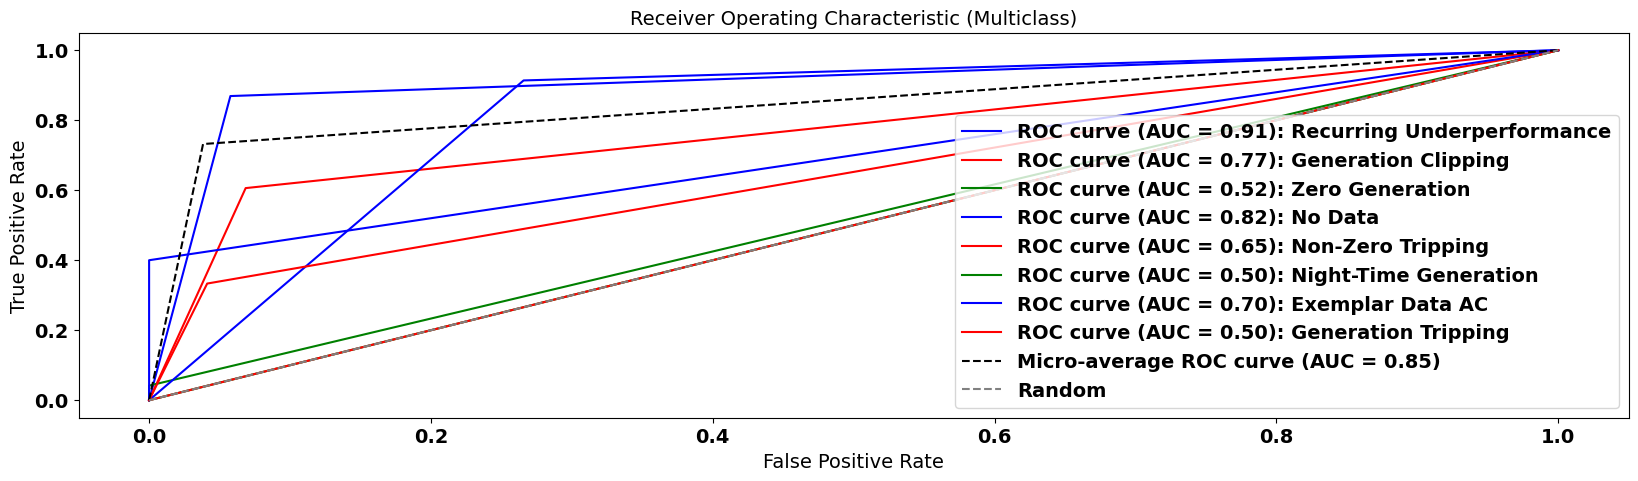

In [80]:
plt_ROC(y_test, y_pred)

[0. 1. 2. 3. 4. 5. 6. 7.]
[0, 1, 2, 3, 4, 5, 6, 7]
['Recurring Underperformance', 'Generation Clipping', 'Zero Generation', 'No Data', 'Non-Zero Tripping', 'Night-Time Generation', 'Exemplar Data AC', 'Generation Tripping']


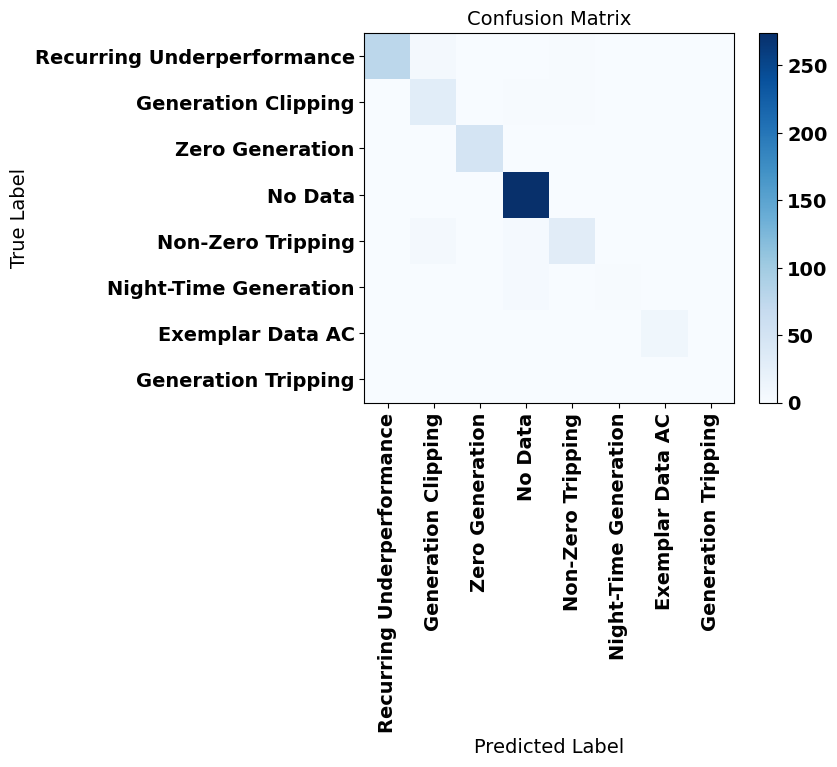

In [56]:
plt_confusion_matrix(y_test, y_pred)

In [57]:
df_ml_raw[df_ml_raw.index.isin(y_test.index)]

,date,05:00:00,05:05:00,05:10:00,05:15:00,05:20:00,05:25:00,05:30:00,05:35:00,05:40:00,...,20:35:00,20:40:00,20:45:00,20:50:00,20:55:00,dcPvsize,faultID,faultname,MID,ClearSky
25,2022-03-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,140000.0,L1F002,Generation Clipping,MNTR|295222,True
29,2022-03-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,140000.0,L1F002,Generation Clipping,MNTR|295222,True
43,2023-04-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,30360.0,L1F011,Non-Zero Tripping,MNTR|7193486a-bebd-4ff8-8c60-ae7000197adf,True
44,2023-04-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,30360.0,L1F011,Non-Zero Tripping,MNTR|7193486a-bebd-4ff8-8c60-ae7000197adf,False
48,2023-02-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,46800.0,L1F011,Non-Zero Tripping,MNTR|304153,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469,2022-12-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2160.0,L1F003,Zero Generation,MNTR|Z23P-Q4S3-Y75B-RGGS,NaN
2477,2022-12-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13000.0,L1F003,Zero Generation,MNTR|7DHI-9YU5-U3WD-48XE,NaN
2480,2022-12-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13000.0,L1F003,Zero Generation,MNTR|7DHI-9YU5-U3WD-48XE,NaN
2490,2022-12-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13000.0,L1F003,Zero Generation,MNTR|WHX2-R9OL-9NA5-DMC8,NaN


In [58]:
y_test_copy = y_test.copy()
y_test_copy.sort_index()

25      1.0
29      1.0
43      4.0
44      4.0
48      4.0
       ... 
2469    2.0
2477    2.0
2480    2.0
2490    2.0
2495    2.0
Name: Label, Length: 500, dtype: float64

## 5.2. Linear SVC

In [59]:
from sklearn.svm import LinearSVC

classifier = LinearSVC(random_state=42)

# Train the classifier on the training data
classifier.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = classifier.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
cal_metrics(y_test, y_pred)


Accuracy: 0.608
Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.74      0.73        84
         1.0       0.29      0.36      0.32        33
         2.0       0.26      0.23      0.24        48
         3.0       0.72      0.74      0.73       278
         4.0       0.29      0.21      0.24        39
         5.0       0.00      0.00      0.00         7
         6.0       1.00      0.40      0.57        10
         7.0       0.00      0.00      0.00         1

    accuracy                           0.61       500
   macro avg       0.41      0.34      0.35       500
weighted avg       0.61      0.61      0.60       500

f1 score: 0.3542811851108603


## 5.3. KNN

In [60]:
knn = KNeighborsClassifier(n_neighbors=8)
# Train the model using the training data
knn.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = knn.predict(X_test)
cal_metrics(y_test, y_pred)

Accuracy: 0.816
Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.92      0.79        84
         1.0       0.46      0.64      0.53        33
         2.0       0.89      0.88      0.88        48
         3.0       0.95      0.90      0.93       278
         4.0       0.63      0.31      0.41        39
         5.0       0.00      0.00      0.00         7
         6.0       0.67      0.60      0.63        10
         7.0       0.00      0.00      0.00         1

    accuracy                           0.82       500
   macro avg       0.54      0.53      0.52       500
weighted avg       0.82      0.82      0.81       500

f1 score: 0.5216085447991189


## 5.4. Decision Tree

In [61]:
from sklearn.tree import DecisionTreeClassifier

In [62]:
# Initialize the Decision Tree classifier
clf = DecisionTreeClassifier()

# Train the classifier using the training data
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)
cal_metrics(y_test, y_pred)

Accuracy: 0.892
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.83      0.83        84
         1.0       0.62      0.70      0.66        33
         2.0       1.00      1.00      1.00        48
         3.0       0.97      0.97      0.97       278
         4.0       0.62      0.62      0.62        39
         5.0       1.00      0.29      0.44         7
         6.0       0.83      1.00      0.91        10
         7.0       0.00      0.00      0.00         1

    accuracy                           0.89       500
   macro avg       0.73      0.67      0.68       500
weighted avg       0.89      0.89      0.89       500

f1 score: 0.6783777573345918


## 5.5. Random Forests

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
# Initialize the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100)

# Train the classifier using the training data
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

cal_metrics(y_test, y_pred)

Accuracy: 0.932
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.90      0.91        84
         1.0       0.72      0.88      0.79        33
         2.0       1.00      1.00      1.00        48
         3.0       0.96      0.97      0.97       278
         4.0       0.84      0.82      0.83        39
         5.0       1.00      0.14      0.25         7
         6.0       1.00      0.90      0.95        10
         7.0       0.00      0.00      0.00         1

    accuracy                           0.93       500
   macro avg       0.81      0.70      0.71       500
weighted avg       0.93      0.93      0.93       500

f1 score: 0.7128532489836414


## 5.6. Naive Bayes

In [65]:
from sklearn.naive_bayes import GaussianNB

In [66]:
# Initialize the Naive Bayes classifier
clf = GaussianNB()

# Train the classifier using the training data
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)
cal_metrics(y_test, y_pred)

Accuracy: 0.612
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.74      0.74        84
         1.0       0.33      0.82      0.47        33
         2.0       0.43      0.73      0.54        48
         3.0       0.97      0.63      0.76       278
         4.0       0.09      0.08      0.08        39
         5.0       0.09      0.14      0.11         7
         6.0       0.33      0.40      0.36        10
         7.0       0.00      0.00      0.00         1

    accuracy                           0.61       500
   macro avg       0.37      0.44      0.38       500
weighted avg       0.74      0.61      0.65       500

f1 score: 0.38392629404299683


## 5.7. Support Vector Machines (SVM)

In [67]:
from sklearn.svm import SVC

In [68]:
# Initialize the SVM classifier
clf = SVC()

# Train the classifier using the training data
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)
cal_metrics(y_test, y_pred)

Accuracy: 0.732
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.87      0.81        84
         1.0       0.38      0.61      0.47        33
         2.0       1.00      0.04      0.08        48
         3.0       0.81      0.91      0.86       278
         4.0       0.41      0.33      0.37        39
         5.0       0.00      0.00      0.00         7
         6.0       1.00      0.40      0.57        10
         7.0       0.00      0.00      0.00         1

    accuracy                           0.73       500
   macro avg       0.54      0.40      0.39       500
weighted avg       0.75      0.73      0.69       500

f1 score: 0.3943004864696649


# 6. Pick up the faulty points

In [69]:
y_test

2291    3.0
1862    0.0
902     0.0
2355    2.0
1285    3.0
       ... 
2051    4.0
1857    1.0
1859    0.0
1151    3.0
461     1.0
Name: Label, Length: 500, dtype: float64

In [70]:
y_test.values

array([3., 0., 0., 2., 3., 2., 3., 3., 3., 0., 3., 3., 2., 3., 4., 3., 3.,
       2., 3., 0., 0., 6., 3., 3., 3., 3., 3., 3., 3., 3., 4., 3., 3., 0.,
       3., 3., 2., 3., 3., 2., 3., 3., 1., 3., 3., 3., 3., 3., 3., 3., 3.,
       0., 2., 1., 6., 3., 1., 0., 0., 4., 2., 3., 3., 3., 3., 3., 0., 3.,
       3., 3., 4., 3., 4., 2., 2., 4., 1., 1., 3., 3., 3., 3., 3., 2., 1.,
       3., 3., 3., 0., 3., 2., 0., 3., 5., 2., 3., 3., 2., 3., 2., 0., 3.,
       0., 3., 3., 0., 3., 0., 4., 1., 3., 0., 1., 0., 0., 3., 3., 3., 4.,
       2., 4., 3., 3., 0., 3., 3., 4., 3., 1., 3., 3., 3., 3., 3., 3., 0.,
       0., 4., 3., 3., 7., 3., 3., 3., 3., 3., 4., 2., 0., 3., 3., 0., 3.,
       3., 3., 1., 2., 3., 3., 3., 3., 4., 4., 3., 3., 0., 3., 4., 3., 3.,
       0., 1., 3., 2., 6., 0., 4., 3., 0., 3., 6., 3., 3., 2., 3., 3., 4.,
       3., 3., 2., 3., 3., 3., 3., 1., 3., 3., 3., 4., 4., 2., 0., 3., 5.,
       4., 3., 0., 3., 3., 3., 3., 3., 0., 3., 3., 3., 3., 1., 3., 0., 3.,
       3., 3., 1., 4., 0.

In [71]:
y_pred

array([3., 0., 0., 3., 3., 3., 0., 3., 3., 0., 3., 3., 3., 3., 1., 3., 3.,
       0., 3., 0., 0., 1., 3., 3., 3., 3., 3., 3., 3., 3., 4., 3., 3., 0.,
       3., 3., 3., 3., 3., 3., 3., 3., 1., 3., 3., 3., 3., 3., 3., 3., 3.,
       0., 3., 1., 6., 3., 1., 0., 0., 4., 3., 3., 3., 3., 3., 3., 0., 3.,
       3., 3., 1., 3., 3., 4., 4., 3., 1., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 0., 3., 3., 0., 3., 3., 3., 3., 3., 3., 3., 3., 0., 3.,
       0., 3., 3., 0., 3., 0., 1., 1., 3., 0., 4., 0., 0., 3., 3., 3., 1.,
       3., 4., 3., 3., 0., 3., 0., 3., 3., 1., 3., 3., 3., 3., 3., 1., 3.,
       0., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1., 3., 0., 0., 3., 0., 3.,
       3., 3., 1., 3., 3., 3., 3., 3., 1., 3., 3., 3., 0., 3., 0., 3., 4.,
       0., 1., 1., 3., 1., 0., 1., 3., 0., 3., 1., 3., 3., 3., 3., 3., 1.,
       3., 3., 3., 3., 3., 3., 3., 1., 3., 3., 3., 3., 1., 3., 0., 3., 1.,
       0., 0., 3., 3., 3., 3., 3., 3., 0., 3., 3., 3., 3., 1., 3., 0., 3.,
       3., 3., 1., 1., 0.

In [72]:
df_ml_raw.iloc[123, :]

date                       2022-01-29
05:00:00                          0.0
05:05:00                          0.0
05:10:00                          0.0
05:15:00                          0.0
                       ...           
dcPvsize                       5000.0
faultID                        L1F011
faultname           Non-Zero Tripping
MID          MNTR|T6OM-8T9V-DW94-DCOY
ClearSky                         True
Name: 123, Length: 198, dtype: object

In [73]:
df_ml_normalized.iloc[123, :]

date                       2022-01-29
05:00:00                     -1.17176
05:05:00                     -1.17176
05:10:00                     -1.17176
05:15:00                     -1.17176
                       ...           
faultID                        L1F011
faultname           Non-Zero Tripping
MID          MNTR|T6OM-8T9V-DW94-DCOY
ClearSky                         True
Label                               4
Name: 123, Length: 199, dtype: object

<Axes: >

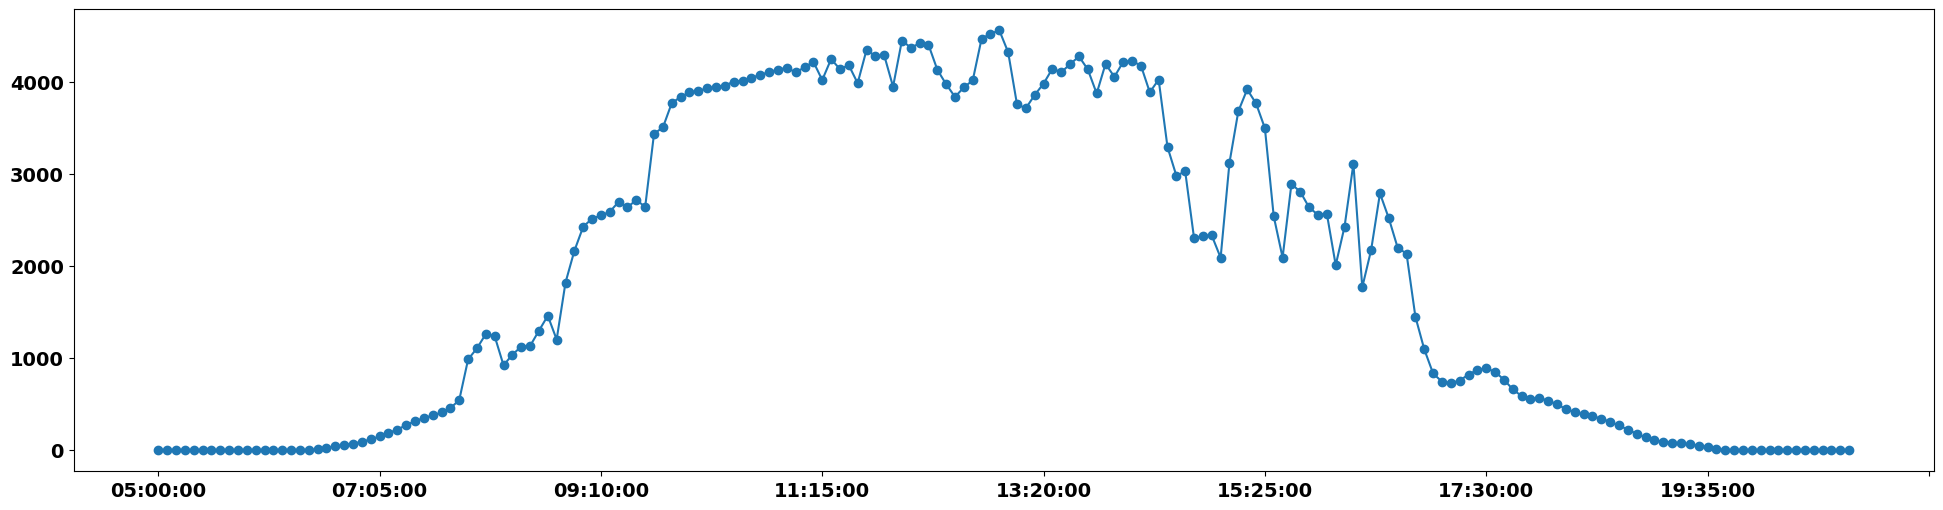

In [74]:
# clipping - recurring
df_ml_raw.iloc[123, 1:193].plot(figsize=(24, 6), marker='o')